In [4]:
#import numpy as np
import torch
#import cv2
from PIL import Image

#from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torchvision import transforms

import model

model load successed


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available() == True:
    print("\n### cuda check ###")
    print(device)                                                           # cuda가 있다면 cuda:0 식으로 출력
    print('Count of using GPUs:', torch.cuda.device_count())    
    print('Current cuda device:', torch.cuda.current_device())
    print()

from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:      # 다운샘플 적용: 입력 데이터의 크기와 네트워크를 통과한 후 출력 데이터의 크기가 다를 경우에 사용
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i  # 아이덴티티 매핑 적용 
        x = self.relu(x)
        
        return x



class Bottleneck(nn.Module):    
    expansion = 4   # 병목 블록을 정의하기 위한 파라미터
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x


class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):   
        layers = []        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)        
        return x, h
        # h는 나오는 텐서, x는 값

from collections import namedtuple      # namedtuple: 튜플의 성질을 갖고 있는 자료형이지만 인덱스뿐만 아니라 키 값으로 데이터에 접근할 수 있다.
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

OUTPUT_DIM = 2  # 2개의 클래스 사용



# image = Image.open("/home/iasl/ws/torch_study/catvsdog/dataset/test_set/test_set/cats/cat.4001.jpg")
# plt.imshow(image)
# plt.show()


### cuda check ###
cuda
Count of using GPUs: 1
Current cuda device: 0



loading dongwoo's model...
tensor([[-4.6893,  5.1649]])
tensor(1)
predicted animal: dog


TypeError: Invalid shape (1, 3, 224, 224) for image data

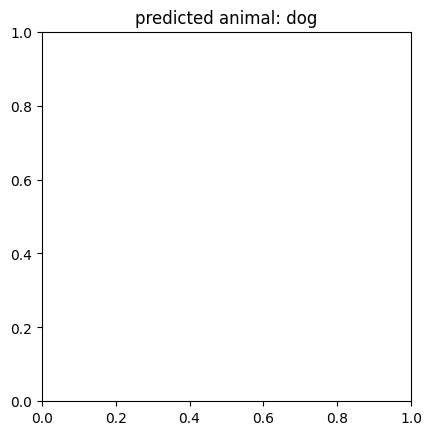

In [7]:


## 모델 예측하기
print("loading dongwoo's model...")
model_path = "ResNet-model_2.pth"
image_path = "/home/iasl/ws/torch_study/catvsdog/test_image/dog.4003.jpg"

#def model_test(image):
# 디바이스 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 객체 생성, 불러오기
dongwoo_model = ResNet(resnet18_config, OUTPUT_DIM)
dongwoo_model.load_state_dict(torch.load(model_path, map_location=device))
dongwoo_model.eval()



# 이미지 전처리 함수 정의
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# 이미지 불러오기
image = Image.open(image_path)
#print(image)

# 이미지 전처리
image_tensor = image_transforms(image).unsqueeze(0)
# print(image_tensor.shape)
image_tensor.to(device)     # 디바이스에 넣음


# 모델 예측

with torch.no_grad():           # 프로세스 실행 후 반납. autograd를 사용하지 않겠다는 의미 - 
    output, _ = dongwoo_model(image_tensor)
    print(output)                                   
    predicted = torch.argmax(output)
    print(predicted)

    # 개 vs 고양이
    predicted_ani = ("cat" if predicted ==0 else "dog")
    predicted_ani = "predicted animal: "+ predicted_ani
    print(predicted_ani)

plt.title(predicted_ani)
plt.imshow(image)
plt.show()



In [ ]:
 = dongwoo_model(image_tensor)
    print(output)                                   
    x = torch.argmax(output[0])

    print(x)
    print(predicted)

    # 개 vs 고양이
    predicted_ani = ("cat" if predicted ==0 else "dog")
    predicted_ani = "predicted animal: "+ predicted_ani
    print(predicted_ani)

plt.title(predicted_ani)
plt.imshow(image)
plt.show()



In [130]:
output

(tensor([[ 0.4417, -0.1110]]),
 tensor([[0.4881, 0.5406, 0.5884, 0.5113, 0.5741, 0.7231, 0.7973, 0.8245, 0.1023,
          0.5535, 0.6144, 0.3246, 0.5256, 0.6120, 0.6957, 0.9879, 0.4355, 0.3759,
          0.6264, 0.3905, 0.6084, 0.9671, 0.0976, 1.0440, 0.7436, 0.1879, 0.0669,
          1.1767, 0.5112, 0.5191, 1.0943, 0.5664, 0.4515, 0.5329, 0.5418, 0.4585,
          0.1653, 0.0815, 0.2424, 0.6730, 0.5611, 0.4288, 0.6081, 0.3803, 0.5368,
          0.6140, 0.6251, 0.4620, 0.6003, 0.2975, 0.5607, 0.5853, 0.7239, 1.0524,
          0.0938, 0.5258, 0.5059, 0.6279, 0.6441, 0.6663, 0.5789, 0.5261, 0.7766,
          0.0180, 0.5613, 0.1938, 0.5801, 0.4567, 0.0117, 0.0938, 0.1061, 0.6616,
          0.5538, 1.3153, 0.6234, 0.6868, 0.3511, 0.6099, 0.0805, 0.6716, 0.0726,
          0.8877, 0.9150, 0.8127, 0.5544, 0.7190, 1.1745, 0.3062, 0.8982, 1.0406,
          0.2061, 0.1708, 0.3086, 1.0184, 0.5707, 0.8161, 0.1336, 0.4997, 0.5216,
          0.6572, 0.5907, 0.4436, 0.3841, 0.1201, 0.5201, 1.1729, 0